# Modelo ResNet-50

En este notebook vamos a implementar el modelo de red neuronal convolucional ResNet-50. Explicaremos a grandes rasgos las distintas partes de la arquitectura. Los detalles pueden ser consultados en el artículo: https://arxiv.org/abs/2201.03545


### Preparación de los datos

Entrenaremos al modelo en el conjunto de datos CIFAR-10. Este dataset consiste de 60000 imágenes a color en 10 clases distintas, donde no hay intersección entre las distintas clases. Se puede acceder al dataset mediante las herramientas de la paquetería de pytorch, o también en la página oficial: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
# Importamos las paqueterías necesarias para el notebook
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# De ser posible utilizaremos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
    """
    Función para cargar los datos de CIFAR-10
    """
    
    # Definimos el transform para normalizar los datos con pytorch
    # Los valores fueron obtenidos en el notebook de datos "data_extraction.ipynb"
    normalize = transforms.Normalize(  
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Definimos el transform para preporcesar los datos
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Tomo imágenes de 34x34 para evitar una excepción en pytorch al normalizar la última capa
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    # Obtener los datos del conjunto de prueba
    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # Cargamos una copia de los datos de entrenamiento
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Cargamos una copia extra de los datos de entrenamiento para dividirlo después en el conjunto de validación
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Separamos los datos de entrenamiento y validación mediante índices
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Finalmente, definimos los conjuntos de entrenamiento y validación
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Aplicamos la función para cargar los datos de CIFAR-10, los guardamos en el directorio actual
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=128)

test_loader = data_loader(data_dir='./data',
                              batch_size=128,
                              test=True)    
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definición del modelo

Explicar el modelo, como lo vamos a construir, como lo vamos a testear. Mencionar que nos vamos a basar en el articulo de ResNet

### Batch normalization

Para evitar el problema *vanishing/exploding gradients*, los autores del artículo emplean *batch normalization*. Para simplificar el uso de este tipo de capa, creamos una capa de utilidad __utilConv__ que aplica una convolución, normalización y la función de activación. La siguiente imagen ejemplifica dicha capa:

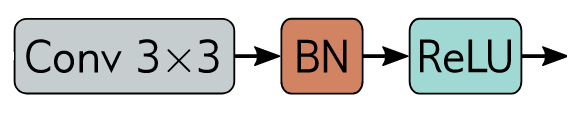

In [3]:
class utilConv(nn.Sequential):
    """
    Capa de utilidad compuesta por una capa de convolución seguida de una de normalización y luego una de activación.
    """
    def __init__(self, in_features, out_features, kernel_size, stride = 1, norm = nn.BatchNorm2d, act = nn.ReLU, bias=True):
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size ,padding=kernel_size // 2, stride=stride, bias=bias),
            norm(out_features),
            act()
        )

### Bottleneck

El bloque residual utilizado en ResNet-50 es conocido como *bottleneck*. Su principal utilidad es el de aumentar el de aumentar la eficiencia de la red neuronal mediante la disminución temporal del número de canales de los datos. La siguiente imagen, tomada del artículo, ejemplifica su funcionamiento:

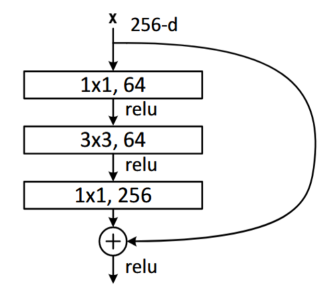

In [4]:
class BottleNeckBlock(nn.Module):
    def __init__(self,in_features, out_features, reduction = 4, stride = 1):
        super().__init__()
        reduced_features = out_features // reduction
        self.block = nn.Sequential(
            # Reducción de canales
            utilConv(in_features, reduced_features, kernel_size=1, stride=stride, bias=False), # el stride puede ser 2 para aplicar downsampling
            # El número de canales se mantiene fijo
            utilConv(reduced_features, reduced_features, kernel_size=3, bias=False),
            # Aumento de canales
            utilConv(reduced_features, out_features, kernel_size=1, bias=False, act=nn.Identity), 
        )
        
        # self.shortcut es utilizado para transformar al input a las dimensiones correctas para poder sumarlo a la salida del bloque
        if in_features != out_features:
            self.shortcut =nn.Sequential(utilConv(in_features, out_features, kernel_size=1, stride=stride, bias=False))
        else:
            self.shortcut = nn.Identity()

        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.block(x)
        res = self.shortcut(res)
        x += res
        x = self.act(x)
        return x

### Stage

La arquitectura ResNet-50 cuenta con 4 conjuntos de bloques _bottlencek_, cada uno de estos conjuntos es llamado *stage*. En la siguiente imagen están encerrados en rojo los 4 _stages_ de la arquitectura ResNet-50

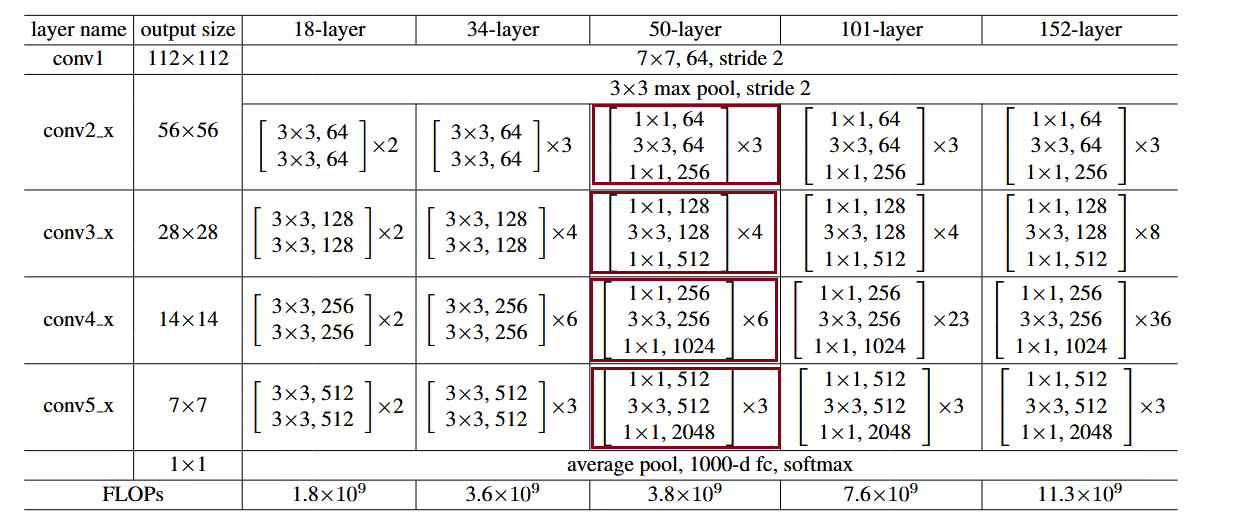

In [5]:
class Stage(nn.Sequential):
    """
    Esta capa define al "stage", el cual es un conjunto de bloques residuales
    depth es el número de bloques residuales
    in_features el numero de canales con que empieza
    out_features el numer de canales con que termina
    """
    def __init__(self, in_features, out_features, depth, stride = 2):
        super().__init__(
            # downsample is done here
            BottleNeckBlock(in_features, out_features, stride=stride),
            *[BottleNeckBlock(out_features, out_features) for _ in range(depth - 1)]
        )

### Estructura "stem cell"

El primer procesamiento al input en el modelo resnet es conocido por el nombre "stem cell", éste consiste en una capa convolucional seguida de una capa de MaxPool. Sin embargo, en el artículo de ResNet deciden no aplicar _downsampling_ al conjunto de datos CIFAR-10, por lo que utilizaremos en la primera convolución un kernel de dimensión 3 y no utilizaremos MaxPool.

In [6]:
class Stem(nn.Sequential):
    def __init__(self, in_features, out_features):
        super().__init__(
            utilConv(in_features, out_features, kernel_size=3, stride=1),  # en el caso de ImageNet, el kernel es de tamaño 7
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  
        )

### Encoder

El Encoder de la arquitectura ResNet abarca todos los elementos mencionados hasta este punto. Es en el Encoder donde se procesan los datos con la intención de extraer sus características principales para después ser clasificados por el Decoder. 

In [7]:
class Encoder(nn.Module):
    
    """
    widths es una lista con el número de canales respectivos al final de cada "stage"
    depths es una lista con el numero de bloques residuales que tendrá cada "stage"
    stem_features es el número de canales que resulta de la primera capa de downsampling
    
    """
    def __init__(self, in_channels, stem_features, depths, widths):  # 
        super().__init__()
        self.stem = Stem(in_channels, stem_features)

        in_out_widths = list(zip(widths, widths[1:]))

        
        self.stages = nn.ModuleList() # lista de pytorch con los stages
        
        self.stages.append(Stage(stem_features, widths[0], depths[0], stride=1)) # se puede inferir de la figura 1 del artículo que el primer bloque del stage1 tiene stride 1
        
        for (in_features, out_features), depth in zip(in_out_widths, depths[1:]):
            # añadir cada uno de los stages
            self.stages.append(Stage(in_features, out_features, depth))
            

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        return x

### Decoder

En ResNet, el Decoder es la parte de la red neuronal encargada de ajustar las dimensiones de los datos procesados por el Encoder para poder clasificarlos. ultimo del resnet fig3 avg pool y fc

In [8]:
class Decoder(nn.Module):
    """
    Capa para clasificar los datos
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        x = F.softmax(x, dim=1)
        return x

In [9]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, stem_features, depths, widths ):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, stem_features=stem_features, depths=depths, widths=widths)
        self.decoder = Decoder(widths[-1], n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Ejemplo de creación y uso del modelo ResNet-50

In [10]:
resnet50 = ResNet(in_channels=3, n_classes = 10, stem_features=16, depths=[3,4,6,4], widths=[16, 32, 64, 64]).to(device)
resnet50(torch.rand(1,3,34,34).to(device)).shape

torch.Size([1, 10])

In [11]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

### Entrenamiento

In [12]:
# variables para guardar los resultados
accuracy_training_epochs = []
accuracy_validation_epochs = []
loss_epoch = []
test_accuracy = []

In [13]:
# hiperparámetros
num_classes = 10
num_epochs = 90

model = ResNet(in_channels=3, n_classes = 10, stem_features=16, depths=[3,4,6,4], widths=[16, 32, 64, 128]).to(device)

optimizer = optim.SGD(
        params=model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=90)

In [14]:
import gc

for epoch in range(num_epochs):
    start_time = time.time()
    for i, (images, labels) in enumerate(train_loader):
        
        # Mover a los tensores a GPU de ser posible
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass y descenso de gradiente estocástico
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Ahorro de memoria
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    loss_epoch.append(loss.item())
    lr_scheduler.step() # Implementación de learning rate decay

    # Exactitud en el conjunto de validación
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        val_accuracy = correct/total
        accuracy_validation_epochs.append(val_accuracy)

    # Exactitud en el total del conjunto de entrenamiento
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        train_accuracy = correct/total
        accuracy_training_epochs.append(train_accuracy)

    # Exactitud en el conjunto de prueba
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        t_acc = correct/total
        test_accuracy.append(t_acc)



    print(f"Epoch [{epoch+1}/{num_epochs}], Training accuracy: {round(train_accuracy,3)}, Validation accuracy: {round(val_accuracy,3)}, loss = {round(loss_epoch[-1],3)}")
    print(f"Time spent on epoch {epoch+1}: {round((time.time()-start_time)/60,2)}min")
    torch.save(model,"./resnet50.pt") # guardar cada epoch para no perder progreso de entrenamiento

Epoch [1/90], Training accuracy: 0.247, Validation accuracy: 0.254, loss = 2.164
Time spent on epoch 1: 1.59min
Epoch [2/90], Training accuracy: 0.279, Validation accuracy: 0.284, loss = 2.183
Time spent on epoch 2: 1.62min
Epoch [3/90], Training accuracy: 0.329, Validation accuracy: 0.329, loss = 2.036
Time spent on epoch 3: 1.63min
Epoch [4/90], Training accuracy: 0.359, Validation accuracy: 0.35, loss = 2.084
Time spent on epoch 4: 1.63min
Epoch [5/90], Training accuracy: 0.379, Validation accuracy: 0.374, loss = 2.053
Time spent on epoch 5: 1.65min
Epoch [6/90], Training accuracy: 0.394, Validation accuracy: 0.397, loss = 2.157
Time spent on epoch 6: 1.65min
Epoch [7/90], Training accuracy: 0.395, Validation accuracy: 0.399, loss = 2.002
Time spent on epoch 7: 1.65min
Epoch [8/90], Training accuracy: 0.425, Validation accuracy: 0.422, loss = 2.054
Time spent on epoch 8: 1.65min
Epoch [9/90], Training accuracy: 0.441, Validation accuracy: 0.445, loss = 2.049
Time spent on epoch 9: 1

Epoch [74/90], Training accuracy: 0.821, Validation accuracy: 0.796, loss = 1.621
Time spent on epoch 74: 1.66min
Epoch [75/90], Training accuracy: 0.82, Validation accuracy: 0.791, loss = 1.647
Time spent on epoch 75: 1.65min
Epoch [76/90], Training accuracy: 0.821, Validation accuracy: 0.794, loss = 1.656
Time spent on epoch 76: 1.65min
Epoch [77/90], Training accuracy: 0.822, Validation accuracy: 0.798, loss = 1.618
Time spent on epoch 77: 1.65min
Epoch [78/90], Training accuracy: 0.825, Validation accuracy: 0.801, loss = 1.572
Time spent on epoch 78: 1.65min
Epoch [79/90], Training accuracy: 0.826, Validation accuracy: 0.8, loss = 1.569
Time spent on epoch 79: 1.66min
Epoch [80/90], Training accuracy: 0.826, Validation accuracy: 0.797, loss = 1.661
Time spent on epoch 80: 1.66min
Epoch [81/90], Training accuracy: 0.828, Validation accuracy: 0.798, loss = 1.641
Time spent on epoch 81: 1.65min
Epoch [82/90], Training accuracy: 0.829, Validation accuracy: 0.795, loss = 1.583
Time spen

In [15]:
# guardar el modelo final
torch.save(model,"./ResNet50_cosine.pt")

### Resultados

In [16]:
import pandas as pd

C:\Users\kosoi\AppData\Local\Temp\ipykernel_8588\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
results_dict = {"loss": loss_epoch,
    'Train':accuracy_training_epochs,
     'Validation': accuracy_validation_epochs,
     "Test":test_accuracy}
results = pd.DataFrame(results_dict)
results.to_csv("./resultsResNet50_cosine.csv",index=False)

In [18]:
A = [(im, label) for (im, label) in train_loader]

In [19]:
A[0][0].shape

torch.Size([128, 3, 32, 32])

In [20]:
results

,loss,Train,Validation,Test
0,2.164049,0.247244,0.2538,0.2518
1,2.183174,0.278756,0.2840,0.2862
2,2.035992,0.328556,0.3292,0.3384
3,2.084471,0.359444,0.3496,0.3644
4,2.052788,0.378844,0.3736,0.3900
...,...,...,...,...
85,1.641941,0.831822,0.8002,0.7915
86,1.683905,0.831933,0.8052,0.7889
87,1.594721,0.833222,0.8120,0.7960
88,1.647408,0.833044,0.8038,0.7964
